In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 

import ts_plots   

# Loading data

In [2]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2018,9,1)

df = web.DataReader('KO', 'yahoo', start, end)

In [3]:
print(df.shape)

(924, 6)


In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,42.400002,41.799999,42.259998,42.139999,9921100.0,37.229038
2015-01-05,42.970001,42.080002,42.689999,42.139999,26292600.0,37.229038
2015-01-06,42.939999,42.240002,42.410000,42.459999,16897500.0,37.511745
2015-01-07,43.110001,42.580002,42.799999,42.990002,13412300.0,37.979980
2015-01-08,43.570000,43.099998,43.180000,43.509998,21743600.0,38.439381


We will concentrate on studying the closing price.

In [5]:
data = pd.DataFrame(df, index=df.index, columns=["Close"], copy=True)
data.index = df.index

In [23]:
data.to_csv()

'Date,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9\n2015-01-02,42.13999938964844,,,,,,,,,\n2015-01-05,42.13999938964844,42.13999938964844,,,,,,,,\n2015-01-06,42.459999084472656,42.13999938964844,42.13999938964844,,,,,,,\n2015-01-07,42.9900016784668,42.459999084472656,42.13999938964844,42.13999938964844,,,,,,\n2015-01-08,43.5099983215332,42.9900016784668,42.459999084472656,42.13999938964844,42.13999938964844,,,,,\n2015-01-09,43.029998779296875,43.5099983215332,42.9900016784668,42.459999084472656,42.13999938964844,42.13999938964844,,,,\n2015-01-12,42.63999938964844,43.029998779296875,43.5099983215332,42.9900016784668,42.459999084472656,42.13999938964844,42.13999938964844,,,\n2015-01-13,42.630001068115234,42.63999938964844,43.029998779296875,43.5099983215332,42.9900016784668,42.459999084472656,42.13999938964844,42.13999938964844,,\n2015-01-14,42.560001373291016,42.630001068115234,42.63999938964844,43.029998779296875,43.5099983215332,42.9900016784668,42.459999084472656,42.13

# Question of stationarity

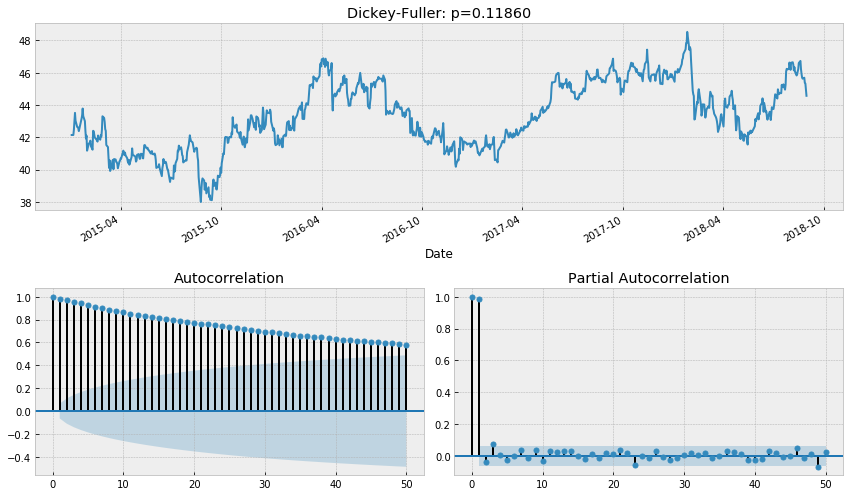

In [7]:
ts_plots.tsplot(data.Close.dropna(), lags=50)

Differentiated series:

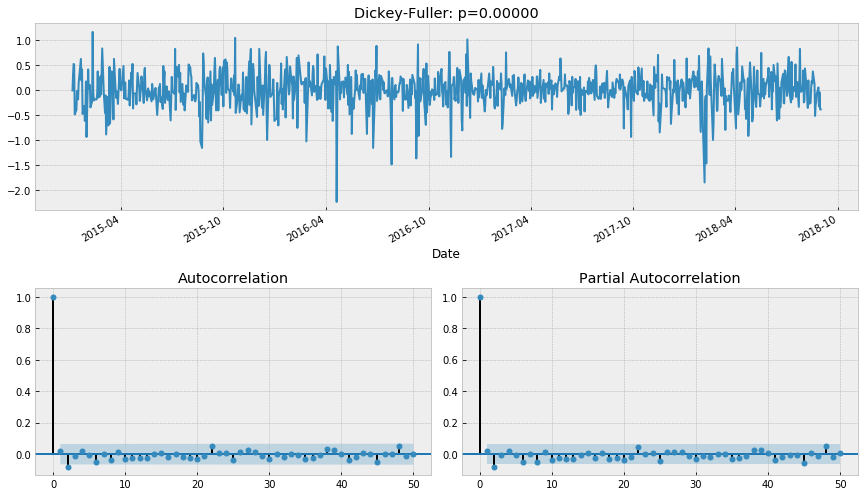

In [8]:
ts_plots.tsplot(data.Close.diff().dropna(), lags=50)

# Targer and predictors

Lagged data:

In [9]:
for i in range(1, 10):
    data["lag_{}".format(i)] = data.Close.shift(i)
data.head(10)

,Close,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
Date,,,,,,,,,,
2015-01-02,42.139999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,42.139999,42.139999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,42.459999,42.139999,42.139999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,42.990002,42.459999,42.139999,42.139999,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,43.509998,42.990002,42.459999,42.139999,42.139999,NaN,NaN,NaN,NaN,NaN
2015-01-09,43.029999,43.509998,42.990002,42.459999,42.139999,42.139999,NaN,NaN,NaN,NaN
2015-01-12,42.639999,43.029999,43.509998,42.990002,42.459999,42.139999,42.139999,NaN,NaN,NaN
2015-01-13,42.630001,42.639999,43.029999,43.509998,42.990002,42.459999,42.139999,42.139999,NaN,NaN
2015-01-14,42.560001,42.630001,42.639999,43.029999,43.509998,42.990002,42.459999,42.139999,42.139999,NaN


In [10]:
y = data.dropna().Close.diff().dropna()
X = data.dropna().drop(['Close'], axis=1).diff().dropna()

np.concatenate(X.iloc[:, 0:1].values)[:20]

array([-0.18000031,  0.14999771,  0.63000107,  0.20000076,  0.41999817,
       -0.46999741, -0.31000137, -0.61000061, -0.47000122,  0.18000031,
       -0.93000031,  0.42000198,  0.04000092,  0.04999924,  0.11000061,
       -0.34000015, -0.22000122,  1.17000198, -0.03000259, -0.20000076])

Histogram of daily price changes

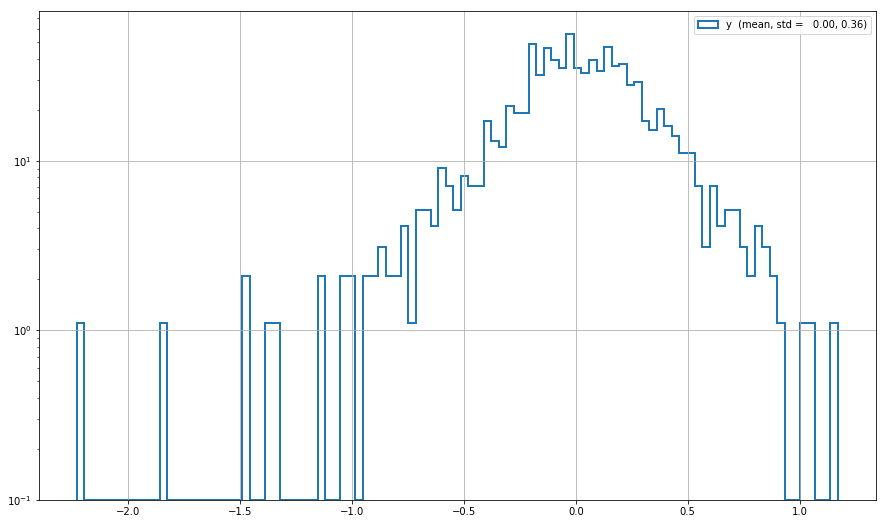

In [11]:
plt.figure(figsize=(15,9))
plt.hist(y, bins=101, bottom=0.1, log=True, histtype='step', linewidth=2.0,
         label="y  (mean, std =   {0:.2f}".format(y.mean())+", {0:.2f})".format(y.std()))
plt.legend()
plt.grid(True);

Correlation corfficients between target and predictors

[ 0.01927065 -0.07869908 -0.01015736  0.02385453 -0.00402722 -0.05080781
 -0.00077939 -0.03886565]


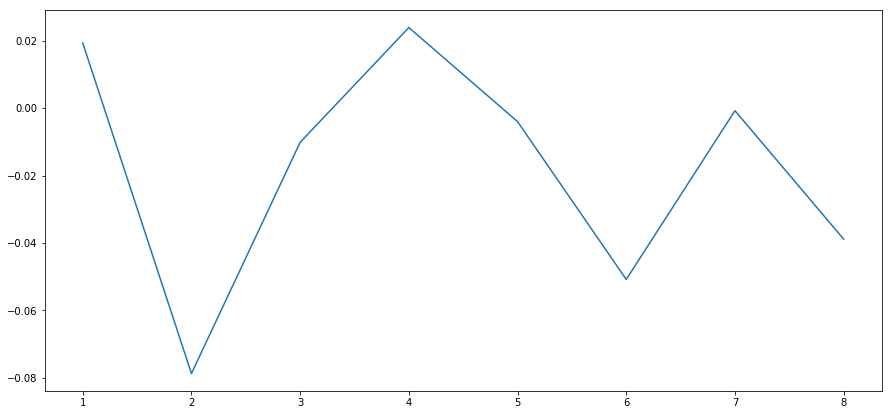

In [12]:
pears_corr_coef = []
for i in range(1,9):
    pears_corr_coef.append(scs.pearsonr(X.iloc[:, i-1:i].values.ravel(), y.values)[0])
    
print(np.array(pears_corr_coef))
plt.figure(figsize=(15,7))
plt.plot(range(1,9), pears_corr_coef)

Splitting the data into train and test parts

In [13]:
X_train, X_test, y_train, y_test = ts_plots.timeseries_train_test_split(X, y, test_size=0.5)

# Simple linear regression forecast

In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

f_train = model.predict(X_train)
corr_fy = (f_train * y_train.values).sum() / ((f_train ** 2).sum() * ((y_train.values ** 2).sum())) ** 0.5
print("Correlation of forecast and y on train data:   {0:.2f}%".format(scs.pearsonr(f_train, y_train.values)[0]*100))
f_test = model.predict(X_test)
corr_ff = (f_test * y_test.values).sum() / ((f_test ** 2).sum() * ((y_test.values ** 2).sum())) ** 0.5
print("Correlation of forecast and y on test data:   {0:.2f}%".format(scs.pearsonr(f_test, y_test.values)[0]*100))

SS_tot = ((y_test.values - y_test.values.mean()) **2).sum()
SS_res = ((f_test - y_test.values) **2).sum()
print("R squared:   {0:.2f}".format(1 - (SS_res / SS_tot)))

Correlation of forecast and y on train data:   8.52%
Correlation of forecast and y on test data:   4.03%
R squared:   -0.00


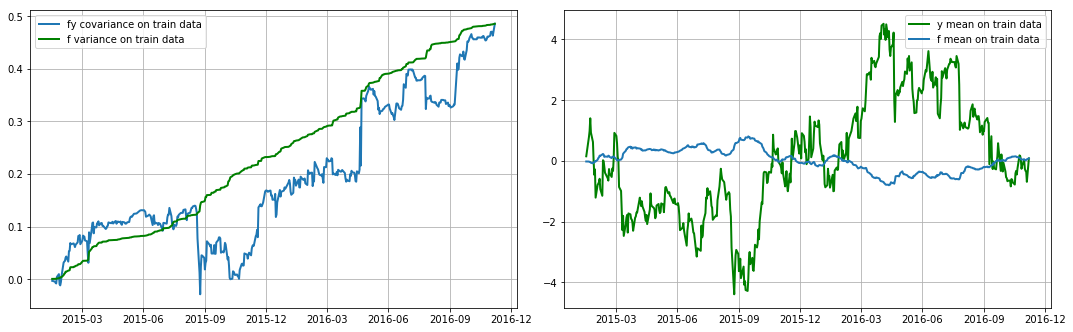

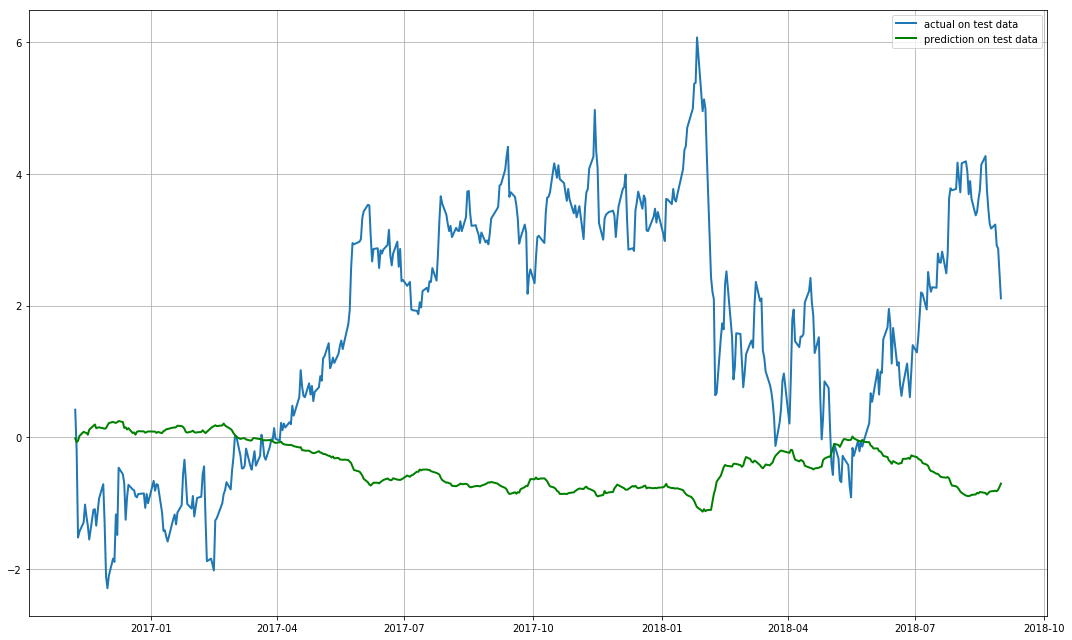

In [15]:
plt.figure(figsize=(15,9))
plt.subplot(221)
plt.plot(y_train.index, ((f_train - f_train.mean()) * (y_train.values - y_train.values.mean())).cumsum(), 
         label="fy covariance on train data", linewidth=2.0)
plt.plot(y_train.index, ((f_train - f_train.mean())** 2).cumsum(), "g", label="f variance on train data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

plt.subplot(222)
plt.plot(y_train.index, (y_train.values).cumsum(), "g", label="y mean on train data", linewidth=2.0)
plt.plot(y_train.index, (f_train).cumsum(), label="f mean on train data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

plt.figure(figsize=(15,9))
plt.plot(y_test.index, y_test.values.cumsum(), label="actual on test data", linewidth=2.0)
plt.plot(y_test.index, f_test.cumsum(), "g", label="prediction on test data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

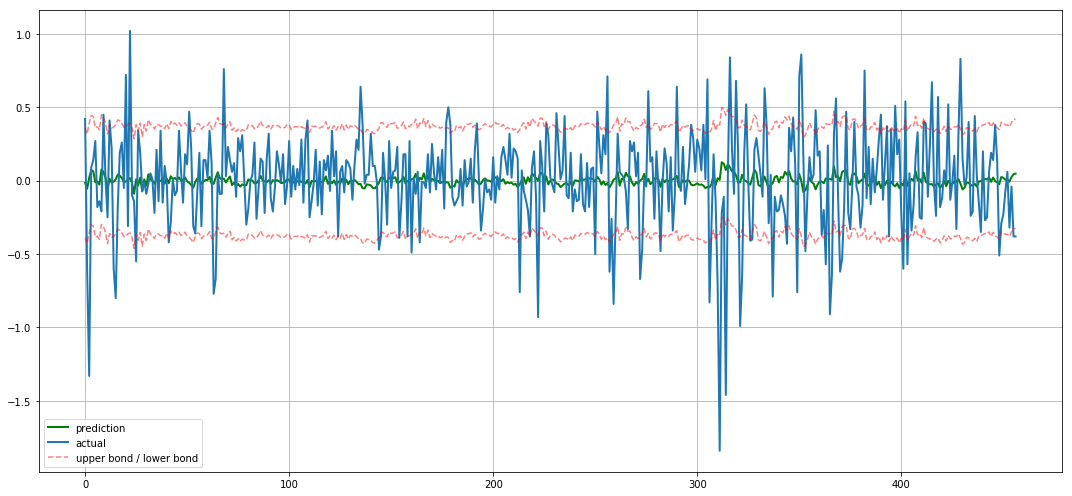

In [16]:
ts_plots.plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=True)

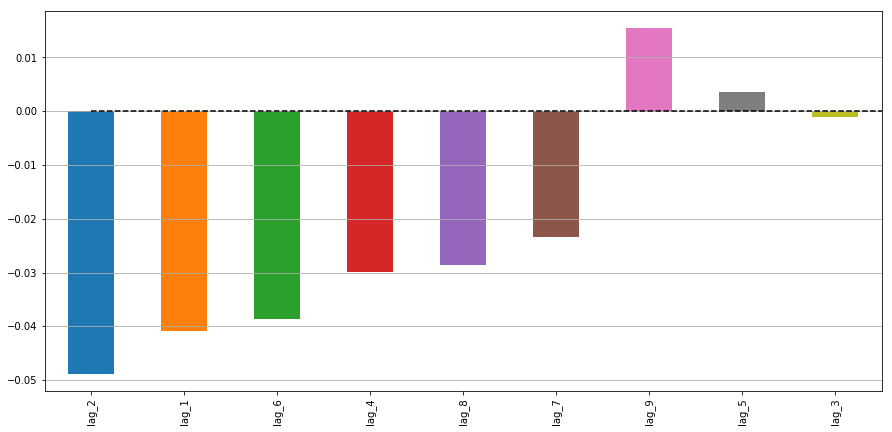

In [17]:
ts_plots.plotCoefficients(model, X_train)

# Ridge regression

In [18]:
from sklearn.linear_model import LassoCV, RidgeCV, Ridge, Lasso

model = Ridge(alpha=20000)
model.fit(X_train, y_train)

f_train = model.predict(X_train)
corr_fy = (f_train * y_train.values).sum() / ((f_train ** 2).sum() * ((y_train.values ** 2).sum())) ** 0.5
print("Correlation of forecast and y on train data:   {0:.2f}%".format(scs.pearsonr(f_train, y_train.values)[0]*100))
f_test = model.predict(X_test)
corr_ff = (f_test * y_test.values).sum() / ((f_test ** 2).sum() * ((y_test.values ** 2).sum())) ** 0.5
print("Correlation of forecast and y on test data:   {0:.2f}%".format(scs.pearsonr(f_test, y_test.values)[0]*100))

SS_tot = ((y_test.values - y_test.values.mean()) **2).sum()
SS_res = ((f_test - y_test.values) **2).sum()
print("R squared:   {0:.2f}".format(1 - (SS_res / SS_tot)))

Correlation of forecast and y on train data:   8.48%
Correlation of forecast and y on test data:   3.63%
R squared:   -0.00


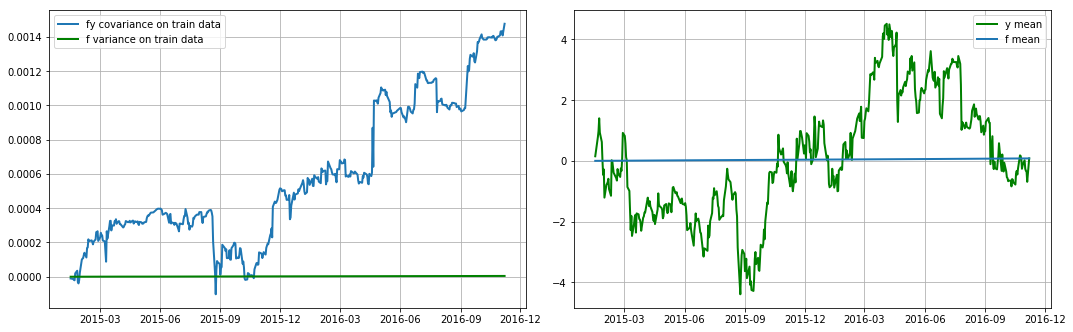

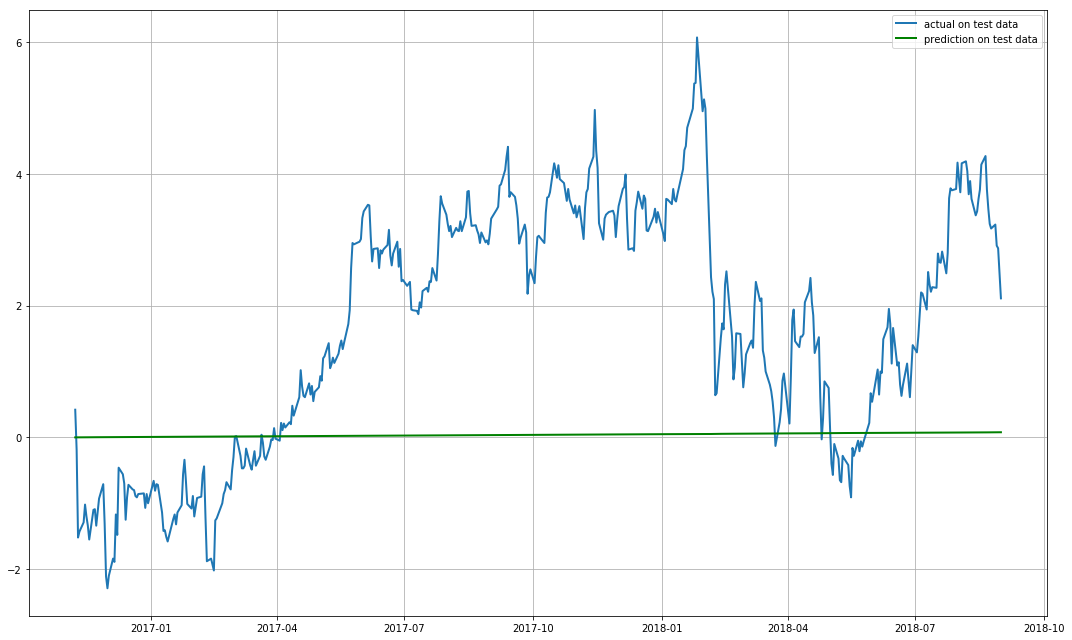

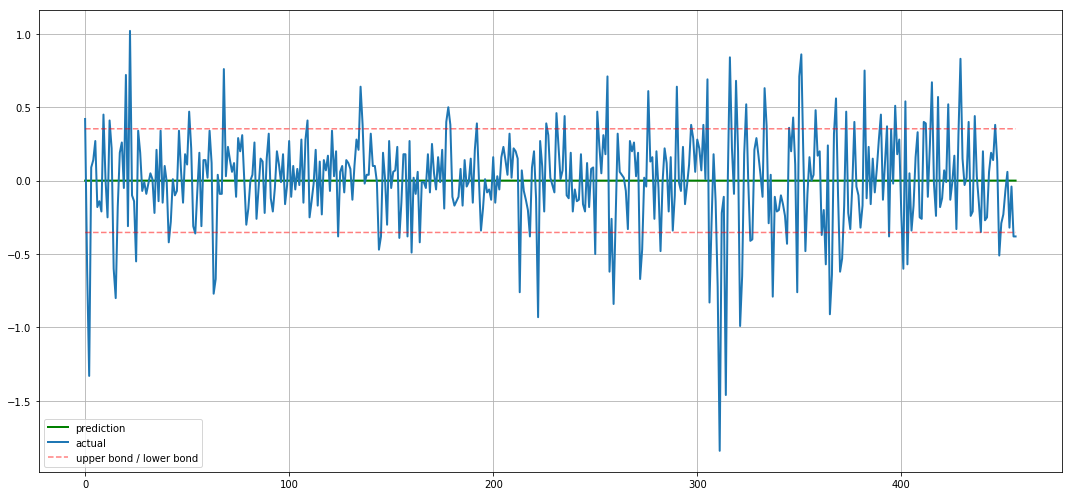

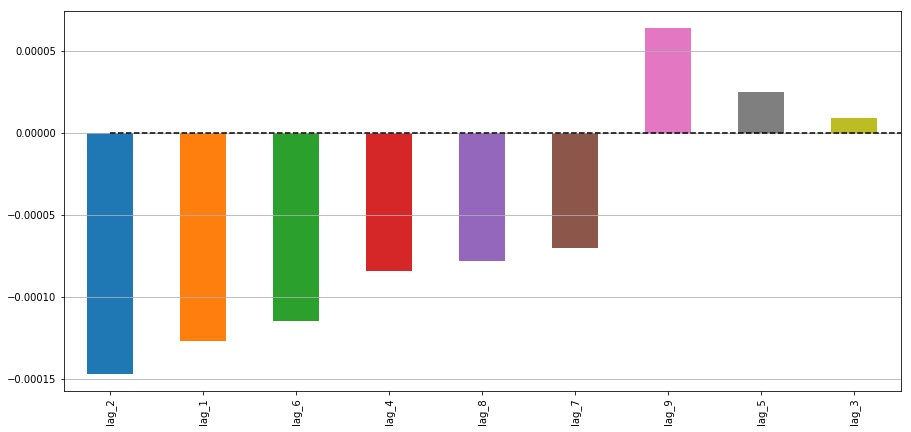

In [19]:
plt.figure(figsize=(15,9))
plt.subplot(221)
plt.plot(y_train.index, ((f_train - f_train.mean()) * (y_train.values - y_train.values.mean())).cumsum(), 
         label="fy covariance on train data", linewidth=2.0)
plt.plot(y_train.index, ((f_train - f_train.mean())** 2).cumsum(), "g", label="f variance on train data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

plt.subplot(222)
plt.plot(y_train.index, (y_train.values).cumsum(), "g", label="y mean", linewidth=2.0)
plt.plot(y_train.index, (f_train).cumsum(), label="f mean", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

plt.figure(figsize=(15,9))
plt.plot(y_test.index, y_test.values.cumsum(), label="actual on test data", linewidth=2.0)
plt.plot(y_test.index, f_test.cumsum(), "g", label="prediction on test data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

ts_plots.plotModelResults(model, X_train, X_test, y_train, y_test, plot_intervals=True)
ts_plots.plotCoefficients(model, X_train)

# XGBoost

In [20]:
from xgboost import XGBRegressor 

xgb = XGBRegressor(max_depth=3, n_estimators=20)
xgb.fit(X_train, y_train)

f_train = xgb.predict(X_train)
corr_fy = (f_train * y_train.values).sum() / ((f_train ** 2).sum() * ((y_train.values ** 2).sum())) ** 0.5
print("Correlation of forecast and y on train data:   {0:.2f}%".format(scs.pearsonr(f_train, y_train.values)[0]*100))
f_test = xgb.predict(X_test)
corr_ff = (f_test * y_test.values).sum() / ((f_test ** 2).sum() * ((y_test.values ** 2).sum())) ** 0.5
print("Correlation of forecast and y on test data:   {0:.2f}%".format(scs.pearsonr(f_test, y_test.values)[0]*100))

SS_tot = ((y_test.values - y_test.values.mean()) **2).sum()
SS_res = ((f_test - y_test.values) **2).sum()
print("R squared:   {0:.2f}".format(1 - (SS_res / SS_tot)))

Correlation of forecast and y on train data:   64.59%
Correlation of forecast and y on test data:   4.02%
R squared:   -0.05


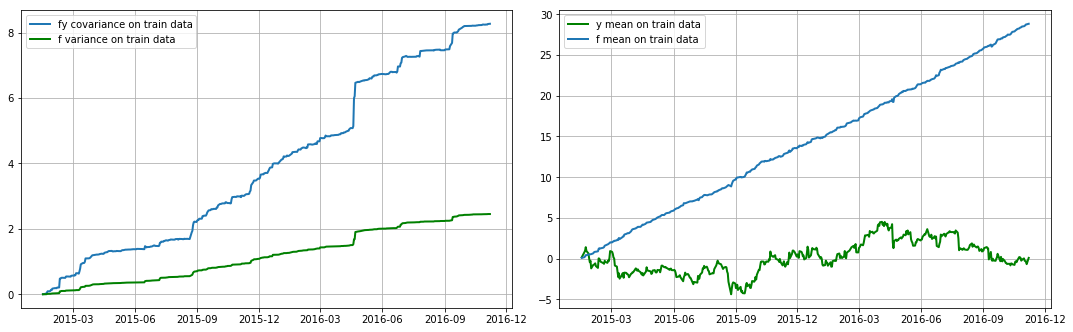

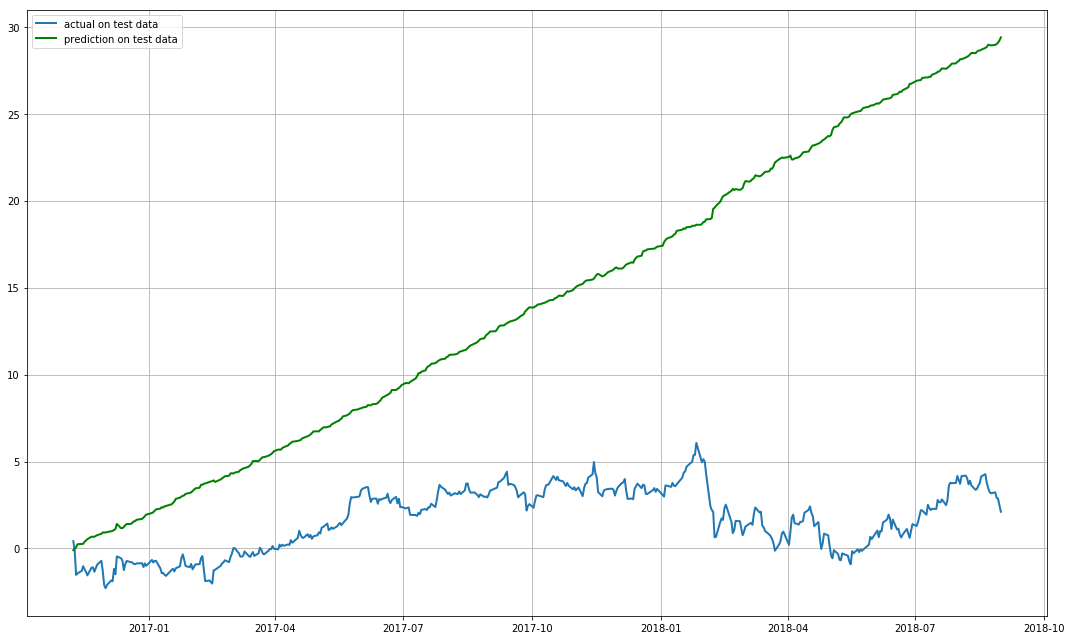

In [21]:
plt.figure(figsize=(15,9))
plt.subplot(221)
plt.plot(y_train.index, ((f_train - f_train.mean()) * (y_train.values - y_train.values.mean())).cumsum(), 
         label="fy covariance on train data", linewidth=2.0)
plt.plot(y_train.index, ((f_train - f_train.mean())** 2).cumsum(), "g", label="f variance on train data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

plt.subplot(222)
plt.plot(y_train.index, (y_train.values).cumsum(), "g", label="y mean on train data", linewidth=2.0)
plt.plot(y_train.index, (f_train).cumsum(), label="f mean on train data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

plt.figure(figsize=(15,9))
plt.plot(y_test.index, y_test.values.cumsum(), label="actual on test data", linewidth=2.0)
plt.plot(y_test.index, f_test.cumsum(), "g", label="prediction on test data", linewidth=2.0)
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

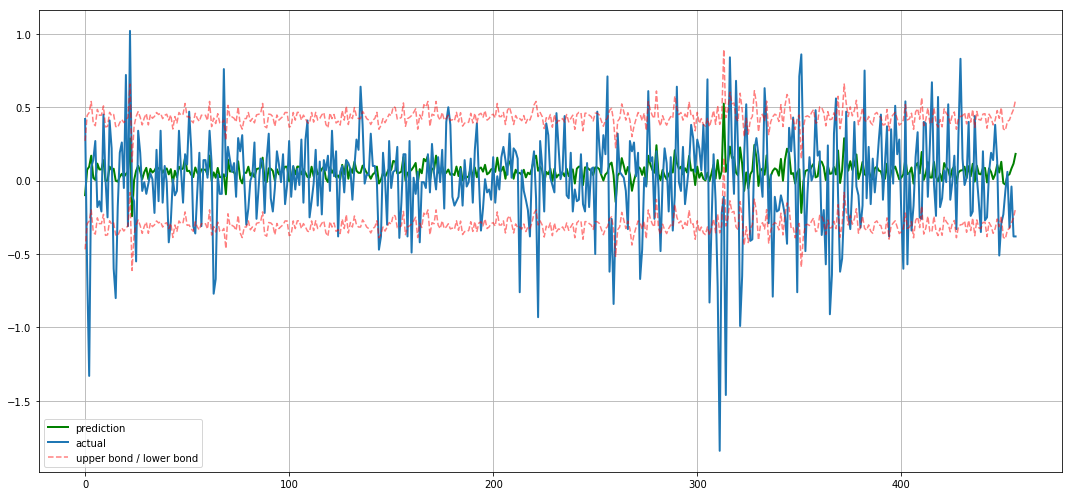

In [22]:
ts_plots.plotModelResults(xgb, X_train, X_test, y_train, y_test, plot_intervals=True)